# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Hide warnings
warnings.filterwarnings('ignore')

In [2]:
# Read dataset, remove unnamed col
df = pd.read_csv('icu-patients.csv', index_col=[0])

# Convert Dataset to tidy format

In [3]:
df = df.melt(id_vars=['ID'], value_vars=df.columns[1:])
df.rename(columns={'variable': 'Feature', 'value': 'Value'}, inplace=True)
df = df.pivot_table(index='ID', columns='Feature', values='Value')
df.reset_index(inplace=True)

# Store format into database

In [4]:
# Store the tidy dataset into a SQLite3 database
conn = sqlite3.connect('icu-patients.db')
df.to_sql('icu_dataset', conn, if_exists='replace')

200

# Get pandas dataframe from database

In [5]:
df = pd.read_sql("""SELECT  ID, Age, AgeGroup, Emergency, Infection, Pulse, Sex, Survive, SysBP 
                    FROM    icu_dataset""", conn)

# 1. Exploratory Data Analysis

### *Assumptions: 
'Survive', 'Emergency', 'Infection': 0 == 'No' and 1 == 'Yes', <br>
'Sex': 0 == 'Male' and 1 == 'Female', <br>
'Pulse': pulse is taken when patient is at rest.

In [6]:
df

,ID,Age,AgeGroup,Emergency,Infection,Pulse,Sex,Survive,SysBP
0,4,87,3,1,1,96,1,0,80
1,8,27,1,1,1,88,1,1,142
2,12,59,2,1,0,80,0,1,112
3,14,77,3,0,0,70,0,1,100
4,27,76,3,1,1,90,1,0,128
...,...,...,...,...,...,...,...,...,...
195,921,50,2,1,0,64,1,0,256
196,923,20,1,1,0,83,0,1,104
197,924,73,3,1,0,100,1,1,162
198,925,59,2,1,0,88,0,1,100


In [7]:
# Check no. of occurence for each binary category
grps = ['Emergency', 'Infection', 'Sex', 'Survive']

for col_name in grps:
    counts = df[col_name].value_counts()
    print(f'\nFeature:{col_name}')
    print(counts)


Feature:Emergency
1    147
0     53
Name: Emergency, dtype: int64

Feature:Infection
0    116
1     84
Name: Infection, dtype: int64

Feature:Sex
0    124
1     76
Name: Sex, dtype: int64

Feature:Survive
1    160
0     40
Name: Survive, dtype: int64


In [8]:
# Find the age range for each age group
age_group = df.groupby("AgeGroup")["Age"].agg(["min", "max"])

print(age_group)

          min  max
AgeGroup          
1          16   49
2          50   69
3          70   92


In [9]:
# Get some basic info of dataframe and check for null entries
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         200 non-null    int64
 1   Age        200 non-null    int64
 2   AgeGroup   200 non-null    int64
 3   Emergency  200 non-null    int64
 4   Infection  200 non-null    int64
 5   Pulse      200 non-null    int64
 6   Sex        200 non-null    int64
 7   Survive    200 non-null    int64
 8   SysBP      200 non-null    int64
dtypes: int64(9)
memory usage: 14.2 KB


(200, 9)

In [10]:
df.describe()

,ID,Age,AgeGroup,Emergency,Infection,Pulse,Sex,Survive,SysBP
count,200.00000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000
mean,444.82000,57.545000,2.025000,0.735000,0.420000,98.92500,0.380000,0.800000,132.280000
std,271.91668,20.054648,0.785788,0.442441,0.494797,26.82962,0.486604,0.401004,32.952099
min,4.00000,16.000000,1.000000,0.000000,0.000000,39.00000,0.000000,0.000000,36.000000
25%,210.25000,46.750000,1.000000,0.000000,0.000000,80.00000,0.000000,1.000000,110.000000
50%,412.50000,63.000000,2.000000,1.000000,0.000000,96.00000,0.000000,1.000000,130.000000
75%,671.75000,72.000000,3.000000,1.000000,1.000000,118.25000,1.000000,1.000000,150.000000
max,929.00000,92.000000,3.000000,1.000000,1.000000,192.00000,1.000000,1.000000,256.000000


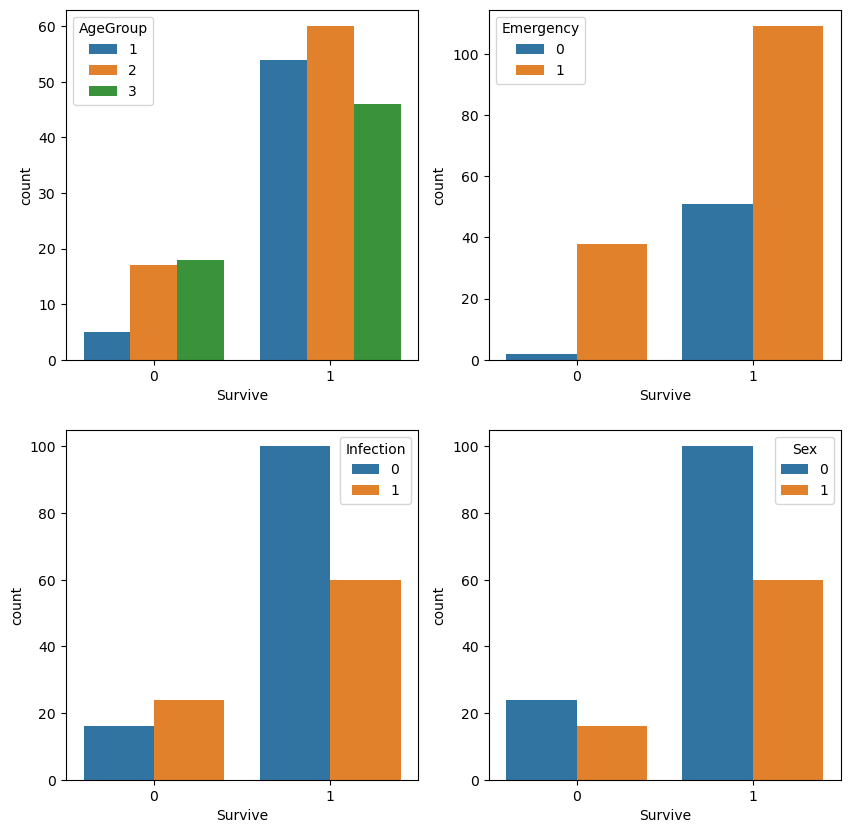

In [11]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
sns.countplot(x='Survive', hue='AgeGroup', data=df, ax=ax[0,0])
sns.countplot(x='Survive', hue='Emergency', data=df, ax=ax[0,1])
sns.countplot(x='Survive', hue='Infection', data=df, ax=ax[1,0])
sns.countplot(x='Survive', hue='Sex', data=df, ax=ax[1,1])
fig.show()

For our non-continous feature variables, we will use a countplot to get some basic insights.

**AgeGroup** <br>
We can see that for ICU patients who do not survive, majority of them belong to the higher age groups, which are 50 and above (as shown above). While for those who survive, it is a slight opposite, where there are more patients from age group 1, which are younger patients aged 50 below. 
Therefore, it can be deduced that age plays a part in whether an ICU patient survives or not.

**Emergency** <br>
Those who do not survive are largely patients who are admitted due to emergencies. There are close to none for non-surviving patients classified as non-emergency. 
What is interesting here is that for those who do survive, there are actually more than 2x the patients for both emergency and non-emergency situations. It can somewhat be infered that there is probably very good healthcare provided for these patients.

**Infection** <br>
Very similar things could be said for infection as with emergency.

**Sex** <br>
What can be said here is that there are more male patients compared to female patients.

**Overall**: Be it the factor, survival rate is considered high for the patients.

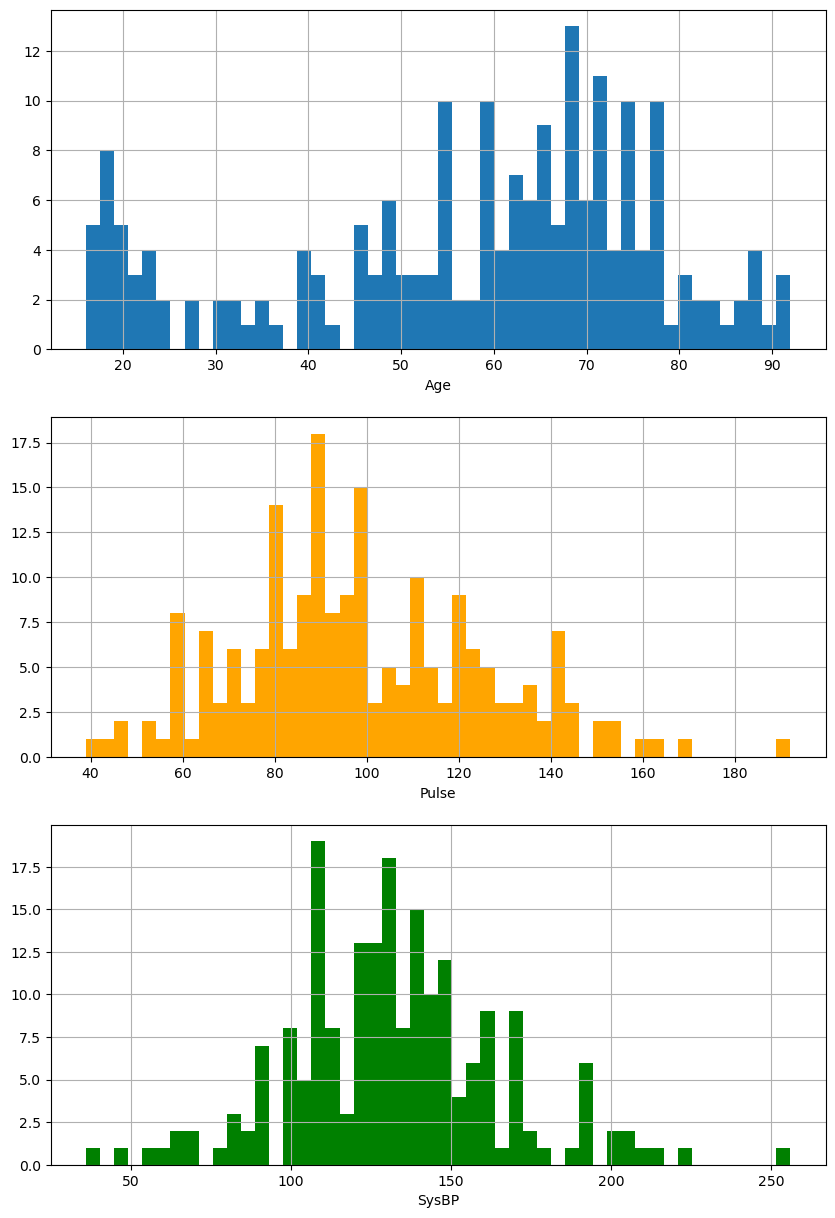

In [12]:
# Show distribution of continuous variables
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
df['Age'].hist(bins=50, ax=ax[0])
df['Pulse'].hist(color='orange', bins=50, ax=ax[1])
df['SysBP'].hist(color='green',bins=50, ax=ax[2])
ax[0].set_xlabel('Age')
ax[1].set_xlabel('Pulse')
ax[2].set_xlabel('SysBP')
plt.show()

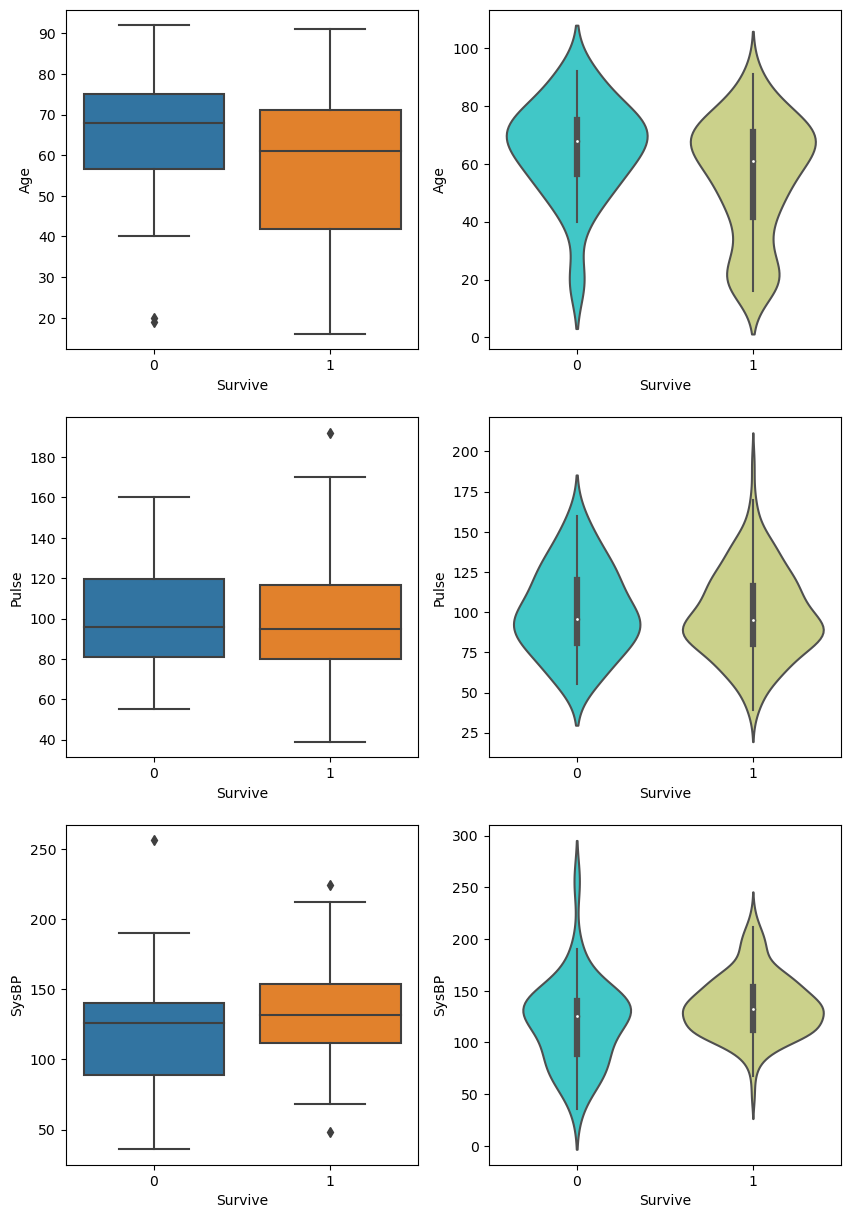

In [13]:
fig, ax = plt.subplots(3,2, figsize=(10, 15))
sns.boxplot(data=df, x='Survive', y='Age', ax=ax[0,0])
sns.boxplot(data=df, x='Survive', y='Pulse', ax=ax[1,0])
sns.boxplot(data=df, x='Survive', y='SysBP', ax=ax[2,0])
sns.violinplot(data=df, x='Survive', y='Age', palette='rainbow', ax=ax[0,1])
sns.violinplot(data=df, x='Survive', y='Pulse', palette='rainbow', ax=ax[1,1])
sns.violinplot(data=df, x='Survive', y='SysBP', palette='rainbow', ax=ax[2,1])
fig.show()

For our continous feature variables, we will use the histogram, boxplot and violin plot to get some basic insights. Differnt plots are provided for convenience and gives viewers the option to look at the plot which makes more sense for them.

**Age** <br>
Here we can see that for those patients who do not survive, there are a few rare cases of patients in their teens (below 20), which could be caused by other factors not considered here. We can see that most of the patients who do not survive are roughly in their late 50s to mid 70s. While those who do survive, have patients who are younger and the overall age of the population is younger. It is noticed that the data is more densed around the age of 60s and 70s, which says that there are alot of elderly patients, which tallies with what we see in AgeGroup above.

**Pulse** <br>
ref link for pulse/heart rate:https://www.healthxchange.sg/men/heart-lungs/heart-rate-myths-facts

Based on the reference link provided, it is said that a healthy heart rate falls in the range of 60-90 beats per minute (bpm).
It can be seen that there are actually quite alot of patients who are above the specified healthy heart range, be it a surviving or non-surviving patient. <br><br>
A naive and out-of-the-box inference is that being a patient probably makes the individual nervous/anxious etc. which could explain the higher reaadings of pulse. Otherwise, it is difficult to provide a much more precise and realistic explanation to the observation, since we assumed that the pulses are taken during rest, and the original dataset does not provide any details/information about how the data were taken/measured.

**SysBP** <br>

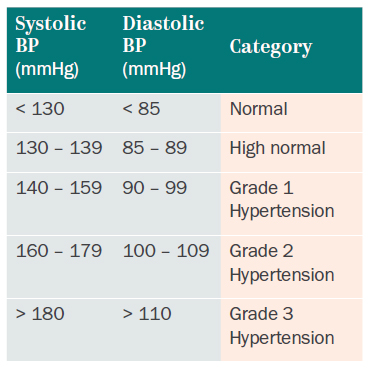
Taken from:https://www.nhcs.com.sg/news/murmurs/understanding-blood-pressure-and-hypertension

ref link for low blood pressure:https://www.healthhub.sg/a-z/diseases-and-conditions/606/postural-hypotension#:~:text=A%20blood%20pressure%20of%20100mmHg,cause%20symptoms%20such%20as%20dizziness.

Inference will be done with the help of the criteria sheet above, taken from National Heart Centre Singapore.
Based on the density of both plot, we can see that there are quite alot of patients who are near the 140 range and may suffer from Grade 1 Hypertension. <br><br>
Looking at the violin plot for this, it is also interesting to note that based on the criteria, those who are below 140 should be normal and can perhaps be considered as healthy. But we can clearly see that for those who do not survive, it includes patients who are in the normal range. <br><br>
One reason to explain this is that low blood pressure is also an issue. From the ref link provided, a SysBP reading of 100 and lower is considered to be low and can lead to many health issues, and who do see this trend in our violin plot. This is further supported by those who survive, we can see that it is most densed around the area where readings are above 100 and somewhere near 140.



**Overall**: It can be assumed that old age and too high or low of an SysBP reading results in a lower chance of surviving.

Text(0.5, 1.0, 'Correlation of features')

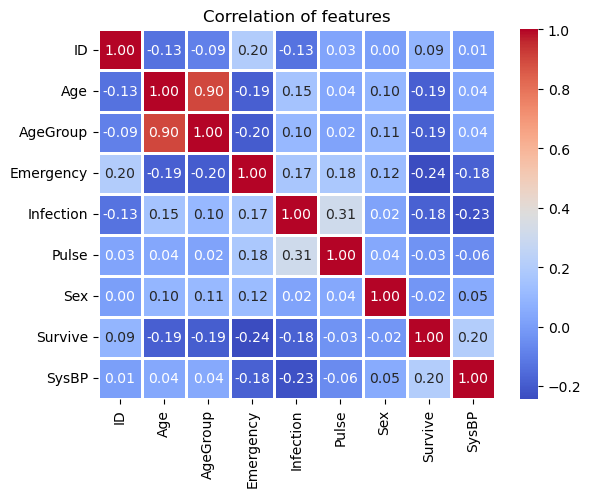

In [14]:
sns.heatmap(df.corr(),annot=True,fmt='.2f',cmap='coolwarm',linewidths=1)
plt.title('Correlation of features')

Based on the heatmap generated, it is suggested that '**Age**' and '**AgeGroup**' are highly correlated which makes sense.
Next closest, we have '**Pulse**' and '**Infection**' at 0.31, '**Pulse**' and '**Emergency**' at 0.18 and '**Emergency**' and '**Infection**' at 0.17.<br><br>
We can use a simple bar plot to check for correlations. As done below.

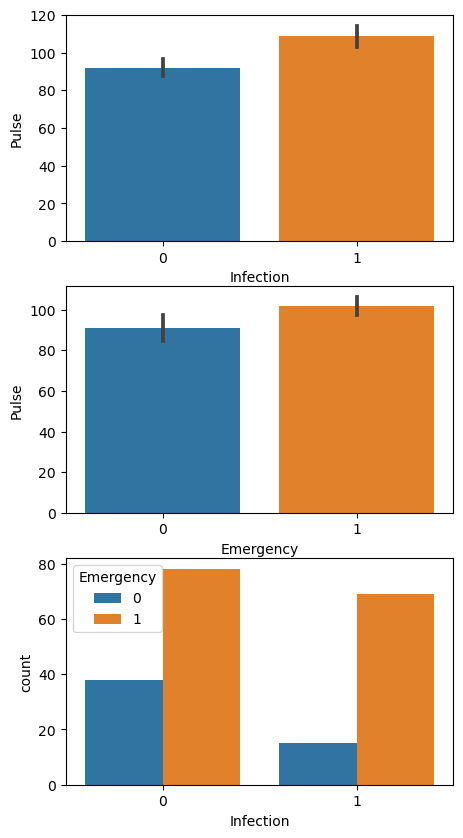

In [15]:
fig, ax = plt.subplots(3,1, figsize=(5, 10))
sns.barplot(x='Infection', y='Pulse', data=df, ax=ax[0])
sns.barplot(x='Emergency', y='Pulse', data=df, ax=ax[1])
sns.countplot(x='Infection', hue='Emergency', data=df, ax=ax[2])
fig.show()

As shown with the plots, the features have weak correlation and it is hard to make proper inference.<br><br>
Pulse rate cannot really tell whether a patient is infected or belong to the emergency category, since the central tendancy for both yes and no are high. Same goes for infection and emergency, since it can be seen that a patient can very well be classified as emergency whether he/she is infected or not.

# Finding optimal hyperparameters for each model

### Using GridSearchCV

In [16]:
# Prepare the data for modeling
X = df.drop(['Survive', 'ID'], axis=1)
y = df['Survive']

# Split the data into training and testing sets, 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
# Declare the models and the params to optimise with
model_params = {
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', random_state=0),
        'params': {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                   'penalty': ['None', 'l1', 'l2', 'elasticnet'],
                   'max_iter': [10, 50, 100, 500, 1000]}
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(random_state=0),
        'params': {'criterion': ['gini', 'entropy', 'log_loss'],
                   'splitter': ['best', 'random']}
    },
    'random_forest': {
        'model': RandomForestClassifier(random_state=0),
        'params' : {'n_estimators': [1, 5, 10, 100],
                    'criterion': ['gini', 'entropy', 'log_loss']}
    }
}

In [18]:
scores = []
k_fold = [5, 10]

for i in k_fold:
    for m_name, m_param in model_params.items():    

        # Use cross fold validation to reduce overfitting and obtain better estimate of performance.
        clf =  GridSearchCV(m_param['model'], m_param['params'], cv=i)
        clf.fit(X_train, y_train)
        scores.append({
            'model': m_name,
            'k-fold': i,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_,
        })

# Print results in df format
res = pd.DataFrame(scores,columns=['model', 'k-fold', 'best_score', 'best_params'])
res.sort_values(by='best_score', ascending=False, inplace=True)
res

,model,k-fold,best_score,best_params
0,logistic_regression,5,0.83125,"{'C': 1, 'max_iter': 50, 'penalty': 'l2'}"
3,logistic_regression,10,0.82500,"{'C': 10, 'max_iter': 10, 'penalty': 'l2'}"
2,random_forest,5,0.80000,"{'criterion': 'gini', 'n_estimators': 100}"
5,random_forest,10,0.79375,"{'criterion': 'entropy', 'n_estimators': 100}"
4,decision_tree,10,0.76250,"{'criterion': 'gini', 'splitter': 'random'}"
1,decision_tree,5,0.75000,"{'criterion': 'entropy', 'splitter': 'best'}"


Reasons why the the above hyperparameters works best for the best model could be because:<br><br>
**K-Fold**: Since dataset is small, a lower k-fold is sufficient and any larger or lower could create more variance.<br>
**C**: Smaller value results in stronger regularisation. 1 is okay here.<br>
**max-iter**: Smaller value of iter due to smaller dataset. Lesser value needed to converge.<br>
**Penalty**: In simple terms, L1 tries to 'remove' less important features from the datasest, whereas L2 'reduces' the importance of less important features. This means L1 works well with large datasets, and L2 works well with smaller datasets. L2 is most likely selected for that reason.

# Prediction using best hyperparameters from GridSearch

In [19]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)

for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    logreg = LogisticRegression(solver='liblinear', C=1, max_iter=50, penalty='l2', random_state=0)
    logreg.fit(X_train, y_train)                    
    predictions = logreg.predict(X_test)

    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.33      0.12      0.18         8
           1       0.81      0.94      0.87        32

    accuracy                           0.78        40
   macro avg       0.57      0.53      0.53        40
weighted avg       0.72      0.78      0.73        40

[[ 1  7]
 [ 2 30]]
              precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.79      0.97      0.87        31

    accuracy                           0.78        40
   macro avg       0.64      0.54      0.53        40
weighted avg       0.72      0.78      0.71        40

[[ 1  8]
 [ 1 30]]
              precision    recall  f1-score   support

           0       0.67      0.22      0.33         9
           1       0.81      0.97      0.88        31

    accuracy                           0.80        40
   macro avg       0.74      0.59      0.61        40
weighted avg       0.78      0.80   

In [20]:
d_tree = DecisionTreeClassifier(criterion='gini', splitter='random', random_state=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

# Perform k-fold cross-validation
scores = cross_val_score(d_tree, X_train, y_train, cv=kfold, scoring='accuracy')
print(f"Accuracy: {scores.mean()*100:.2f}%")
print(f"Std: {scores.std()*100:.2f}%")

# Train the model using the training data
d_tree.fit(X_train, y_train)

# Perform predictions on the test data
predictions = d_tree.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test,predictions))

Accuracy: 70.62%
Std: 9.70%
              precision    recall  f1-score   support

           0       0.17      0.20      0.18         5
           1       0.88      0.86      0.87        35

    accuracy                           0.78        40
   macro avg       0.52      0.53      0.53        40
weighted avg       0.79      0.78      0.78        40

[[ 1  4]
 [ 5 30]]


In [21]:
rfc = RandomForestClassifier(criterion='gini', random_state=0) # n_estimator=100 by default
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Perform k-fold cross-validation
scores = cross_val_score(rfc, X_train, y_train, cv=kfold)

print(f"Accuracy: {scores.mean()*100:.2f}%") 
print(f"Std: {scores.std()*100:.2f}%")

# Train the model using the training data
rfc.fit(X_train, y_train)

# Perform predictions on the test data
predictions = rfc.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test,predictions))

Accuracy: 74.38%
Std: 5.38%
              precision    recall  f1-score   support

           0       0.20      0.20      0.20         5
           1       0.89      0.89      0.89        35

    accuracy                           0.80        40
   macro avg       0.54      0.54      0.54        40
weighted avg       0.80      0.80      0.80        40

[[ 1  4]
 [ 4 31]]


**Conclusion**: Based on the accuracy given, the optimised models perform quite well with accuries at around 80% and above.<br><br>
Based on the precision, recall and f1-score, we can see that the accuracies for classifying surviving patients are very high. However, the same cannot be said for non-surviving patients.<br><br>
Some explanations for this could include an imbalanced dataset. If we go back to the top and look at the number of survivng patients to non-surviving patients, it is 160:40. There is not enough samples of non-surviving patients to train on. Another reason could be that we might need more feature inputs to get a more accurate prediction.<br><br>
Overall, Logistic Regression has the highest accuracy becuase it is a linear model, which is perfect for our binary classfiication problem here. Whereas Decision Tree and Random Forest are non-linear models and may not always work well for binary classification.<br><br>
It is also important to note that the hyperparameters used also greatly affect the performance of the model. The hyperparameters defined for optimisation above are by no means exhaustive. Therefore, more resources have to be invested to better determine what are the best hyperparameters for each model relative to the dataset used.

In [22]:
# Close db connection once done
conn.close()